In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl


In [2]:
# Imports
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date
import ast
import re
import math

# Scikit Learn
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# Set output of transformers to dataframe
set_config(display='diagram', transform_output='pandas')

In [4]:
# Use the exported data set from above
df2 = pd.read_pickle('/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl')

Text(0.5, 1.0, 'Distribution of Missing Values across the Data Set')

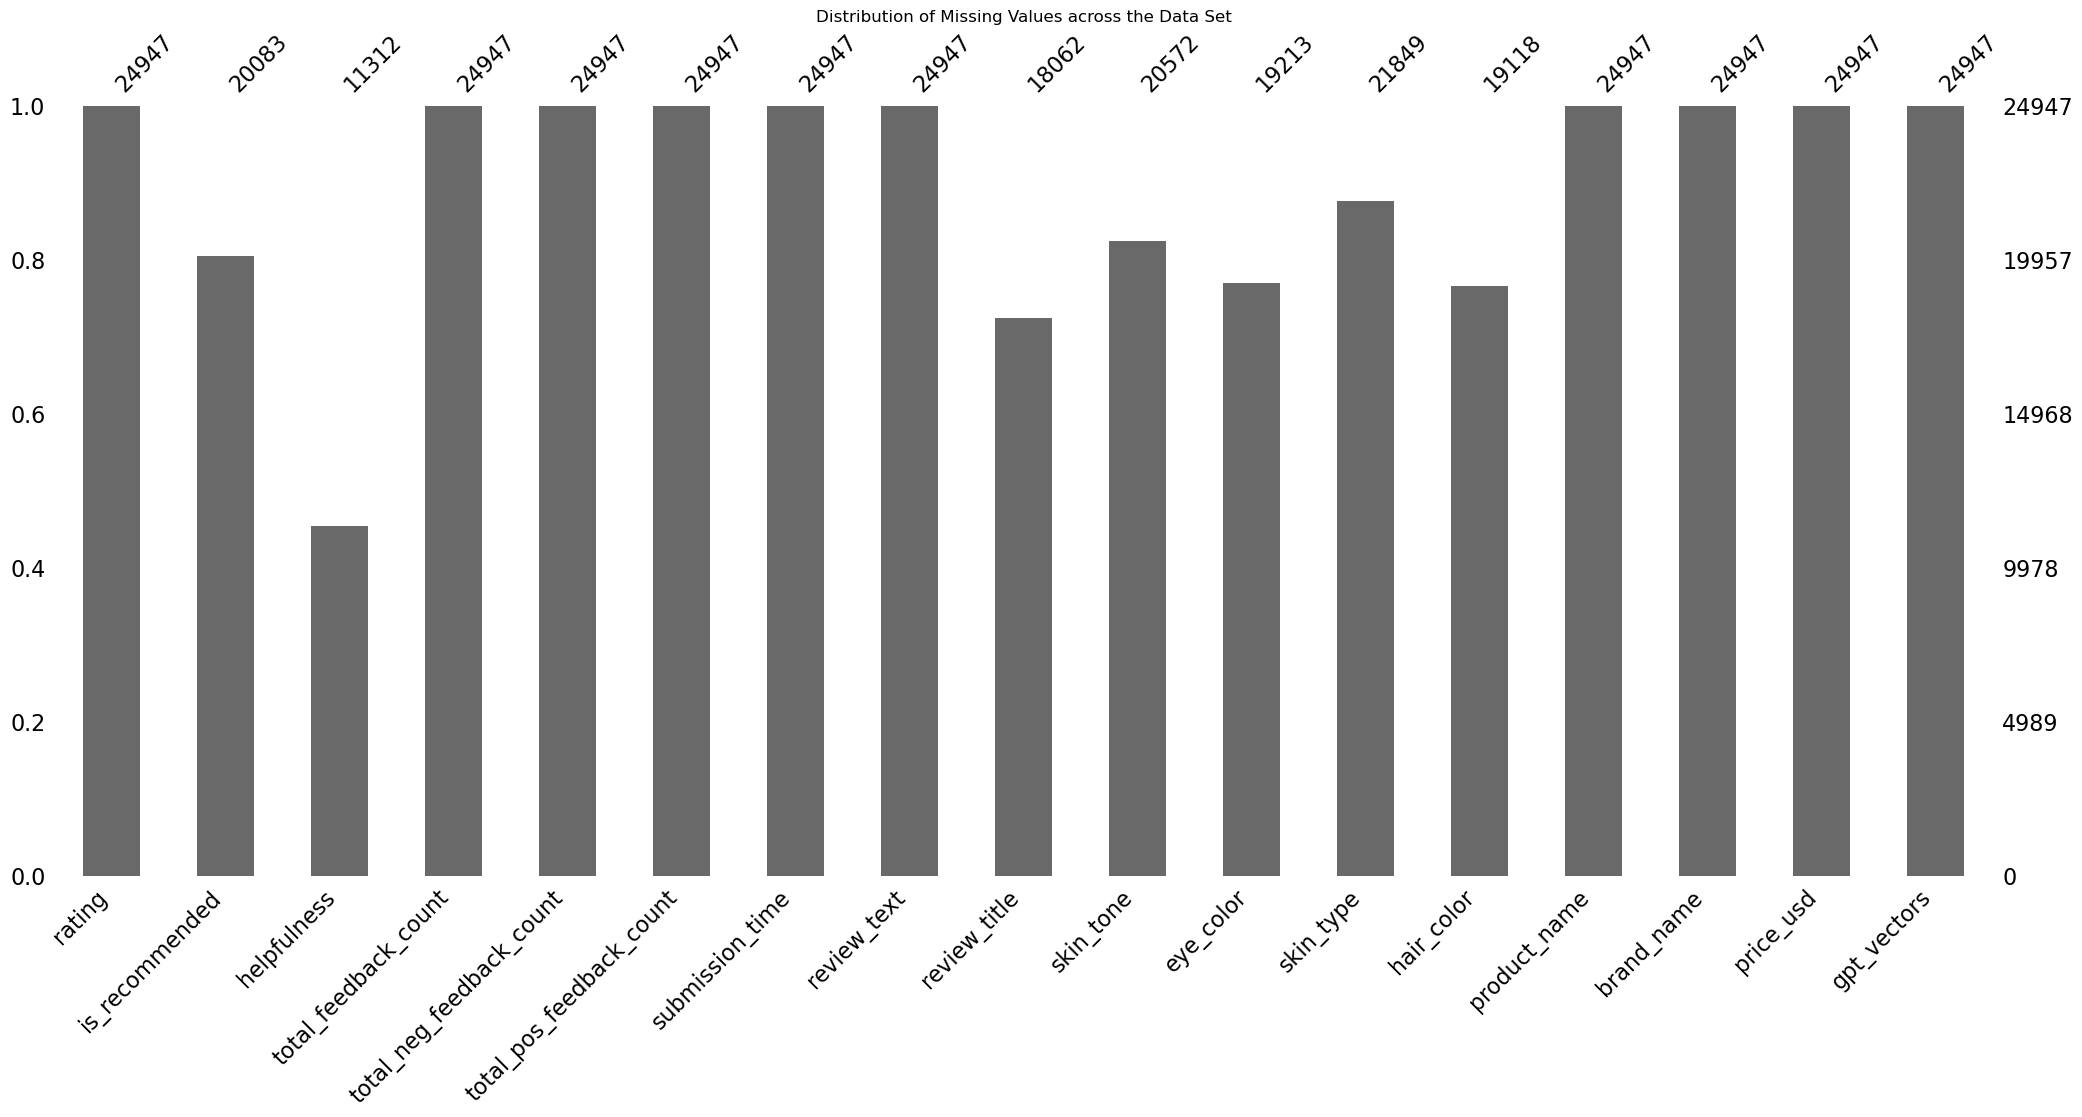

In [5]:
# Visualize the missing values
msno.bar(df2)

# Title
plt.title('Distribution of Missing Values across the Data Set')

Text(0.5, 1.0, 'Nullity Correlations')

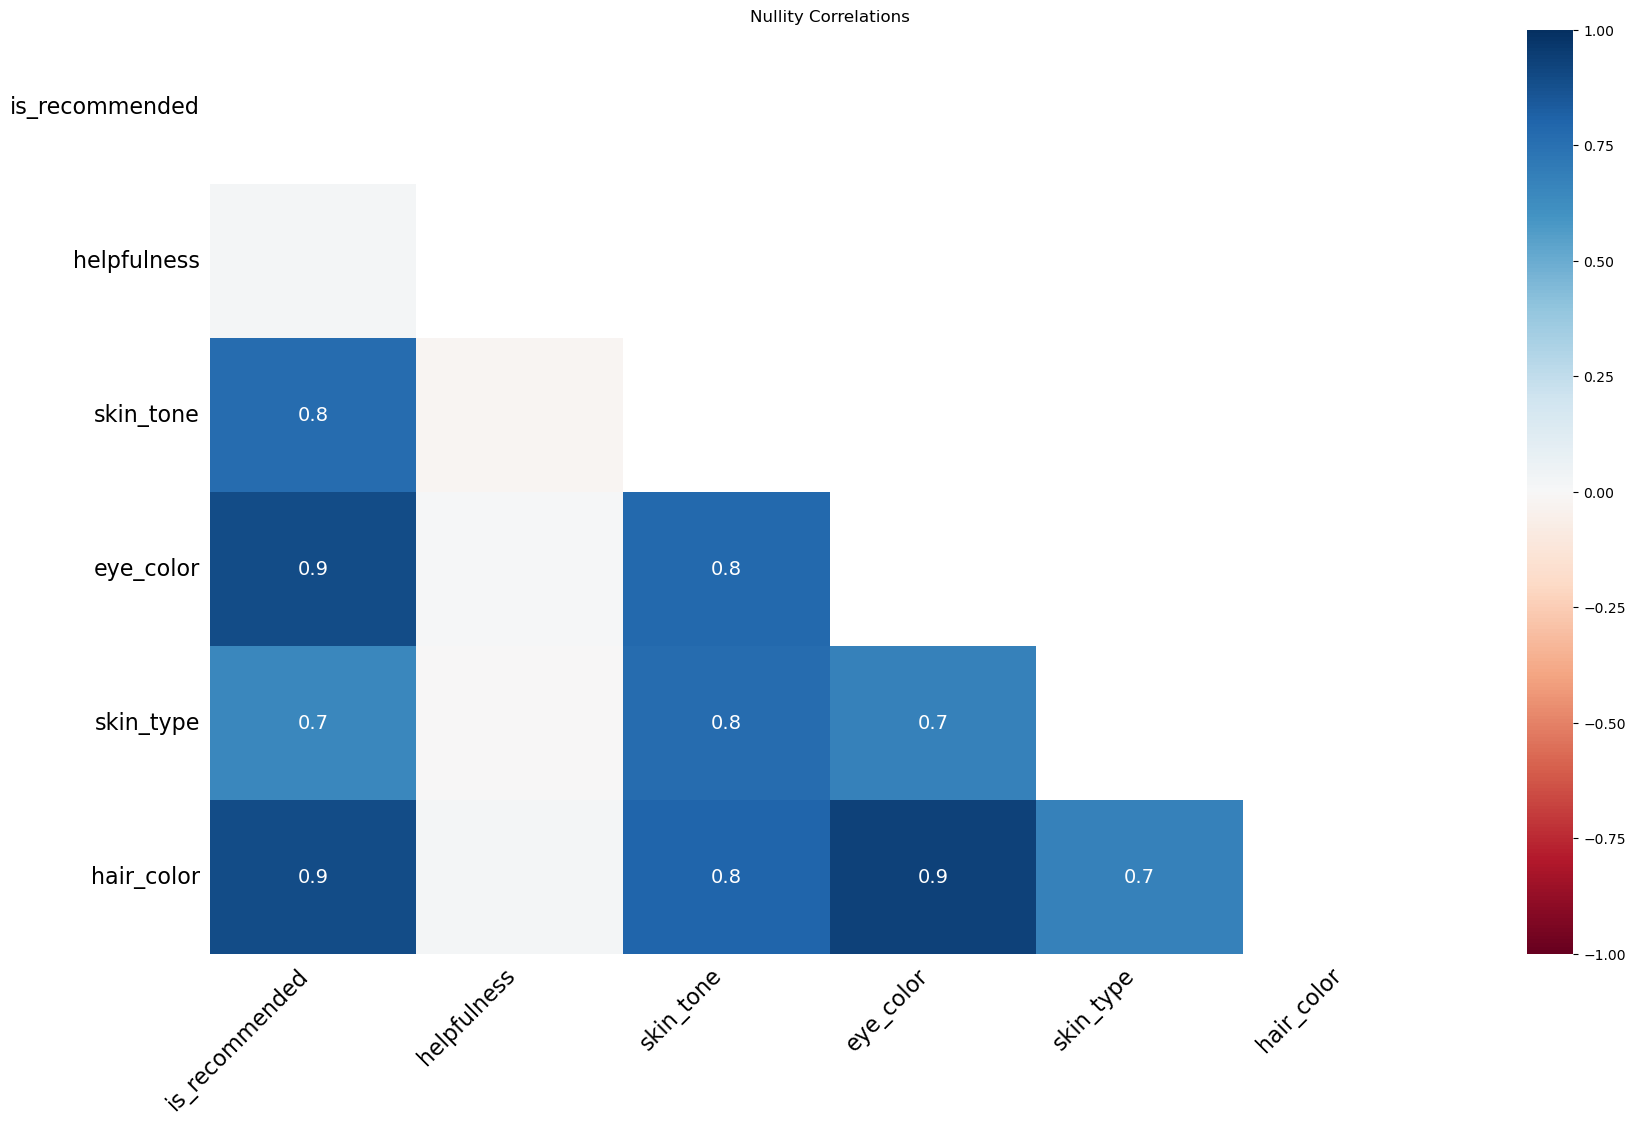

In [6]:
# Correlations among columns with missing values
heatmap_cols = [c for c in df2.columns if c != 'review_text' and c != 'review_title']

# Visualize
msno.heatmap(df2[heatmap_cols])

# Title
plt.title('Nullity Correlations')

### Remove Outliers based on Price USD

In [7]:
# Price USD - find outliers and remove them from the analysis
df2.price_usd.describe()

count    24947.000000
mean        45.423228
std         35.863111
min          3.000000
25%         22.000000
50%         38.000000
75%         58.000000
max        380.000000
Name: price_usd, dtype: float64

Text(0.5, 1.0, 'Price (USD) Boxplot')

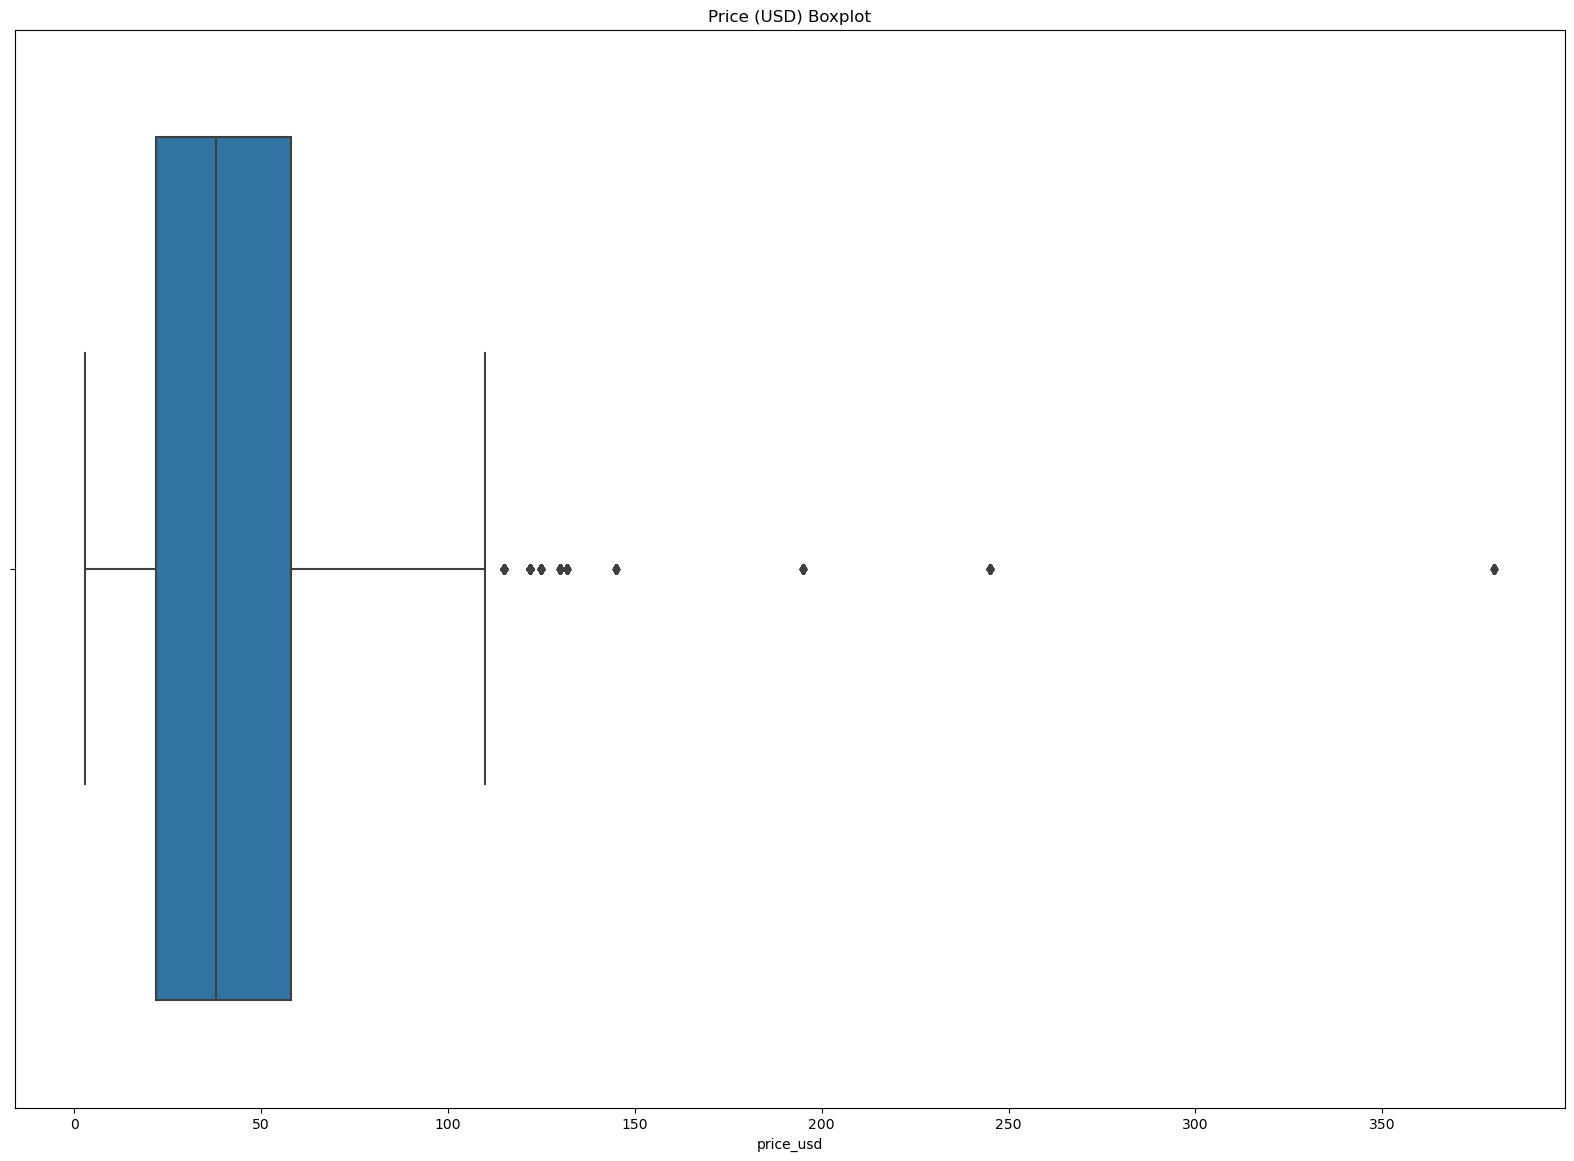

In [8]:
# Boxplot
# Size
plt.figure(figsize=(20,14))

# Boxplot
price_boxes = sns.boxplot(data=df2, x='price_usd')

# Titling
plt.title('Price (USD) Boxplot')

In [9]:
# Reset index in df2
df2.reset_index(drop=True, inplace=True)

# Simple Linear Regression

This will combine GPTVectorizer output with Scikit Learn's Linear Regression. The goal will be to see how good of a model for predicting price can be built based on the review. (Spoiler alert: It won't be impressive. Still, this is fun to try!)

- GPTVectorizer returns vectors between -1 and 1, so MaxAbsScaler will be used to bring price_usd onto the same scale.

# Prepare for Functional Model

In [10]:
# Identify the outlier values using Tukey's fence method
q1 = df2.price_usd.quantile(.25) # First quantile
q3 = df2.price_usd.quantile(.75) # Third quantile
iqr = q3-q1 # Interquartile range

# Inner fence lower and upper end
inner_fence_le = q1 - (1.5*iqr)
inner_fence_ue = q3 + (1.5*iqr)
    
# Outer fence lower and upper end
outer_fence_le = q1 - (3*iqr)
outer_fence_ue = q3 + (3*iqr)

# Outlier values
outliers = []

# Only find those that lay outside the outer fence values
for idx, i in enumerate(df2.price_usd):
    if i <= outer_fence_le or i >= outer_fence_ue:
        outliers.append(idx)

In [11]:
# Number of outliers
print(f'There are {len(outliers)} outliers in the price variable')

There are 278 outliers in the price variable


In [12]:
# Remove outliers
df2 = df2.drop(index=outliers, axis=1)

# Reset index
df2.reset_index(drop=True, inplace=True)

# Check
df2.shape

(24669, 17)

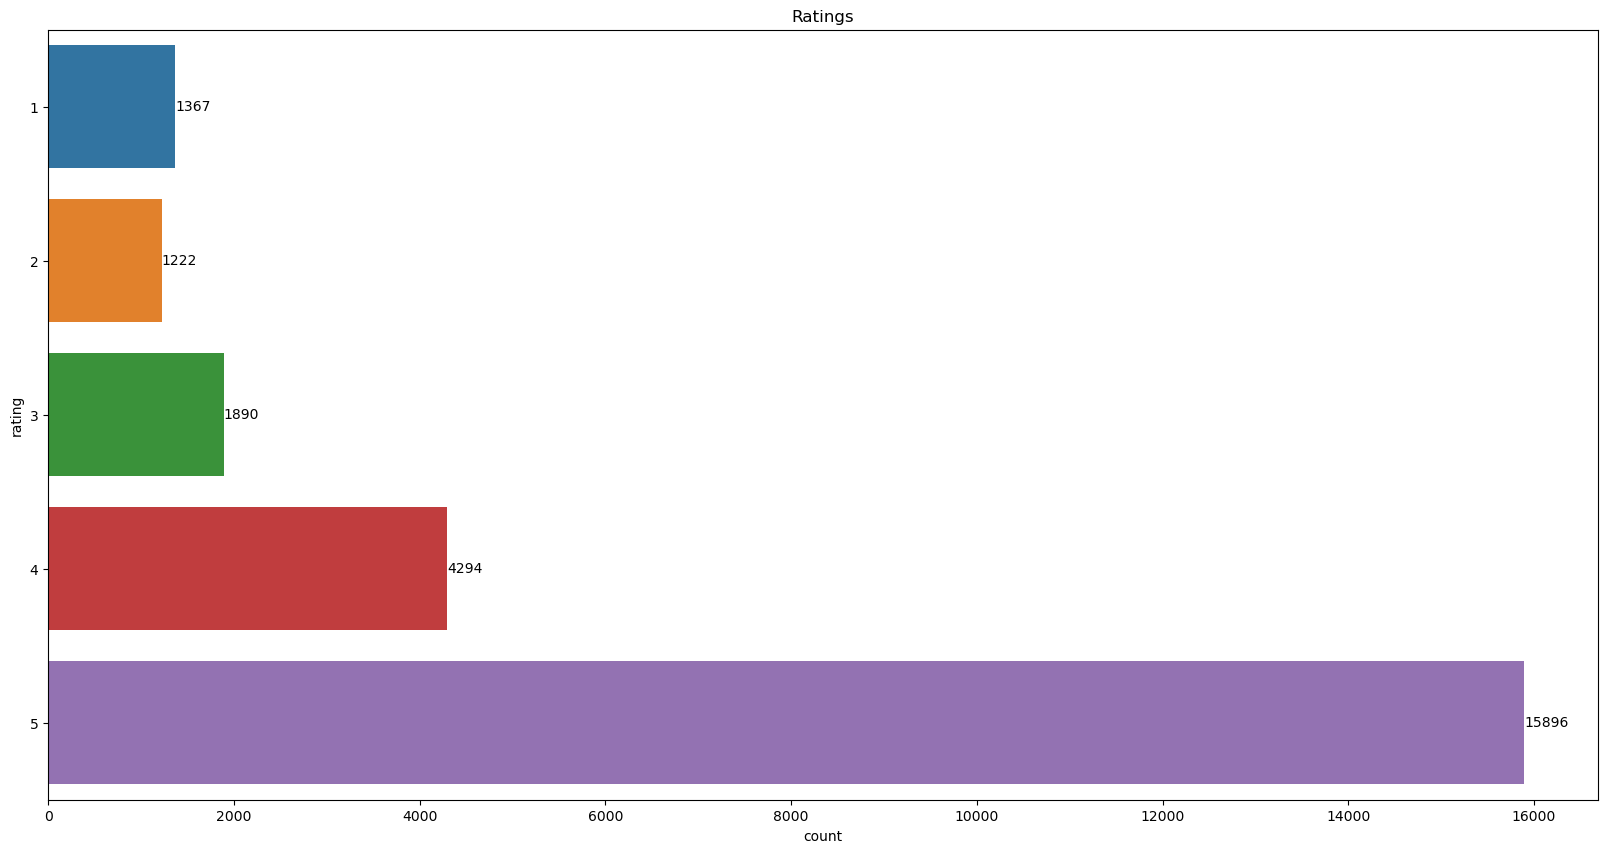

In [13]:
# Ratings
# Size
plt.figure(figsize=(20,10))

# Countplot
ratings_countplot = sns.countplot(y='rating', data=df2)
ratings_countplot.bar_label(ratings_countplot.containers[0]) # Annotations
plt.title('Ratings') # Title

# Show
plt.show()

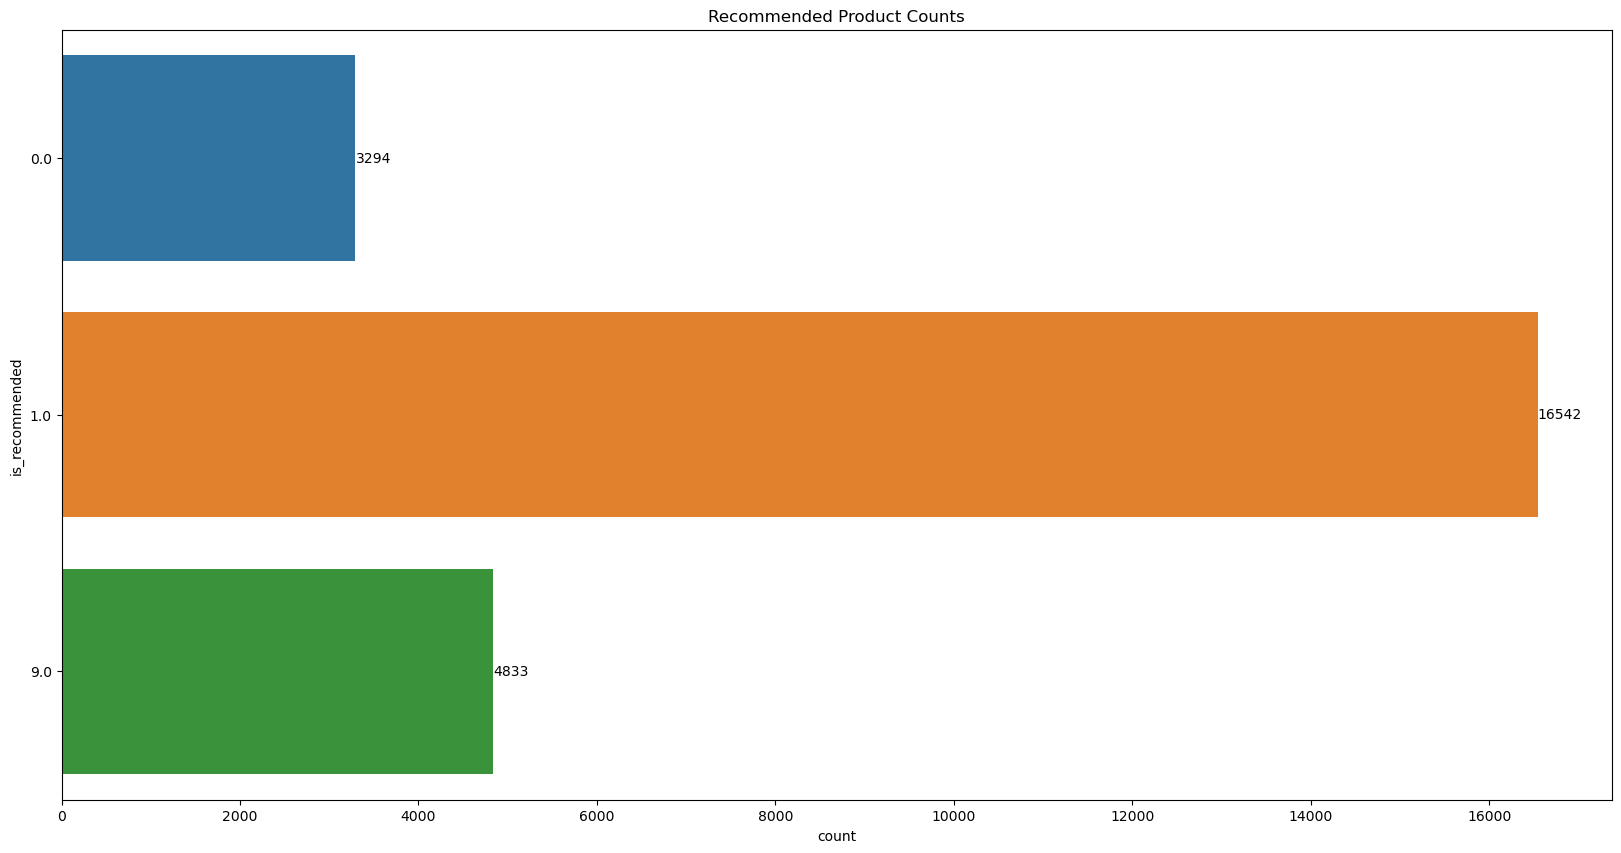

In [14]:
# is_recommended - this will have some null values that will need to be handled.
# The lack of a recommendation either way may also be interesting going forward.
# NaN will be replaced with 9
df2.is_recommended.fillna(9, inplace=True)

# Size
plt.figure(figsize=(20,10))

# Countplot
recommended_countplot = sns.countplot(y='is_recommended', data=df2)
recommended_countplot.bar_label(recommended_countplot.containers[0]) # Annotations
plt.title('Recommended Product Counts') # Title

# Show
plt.show()

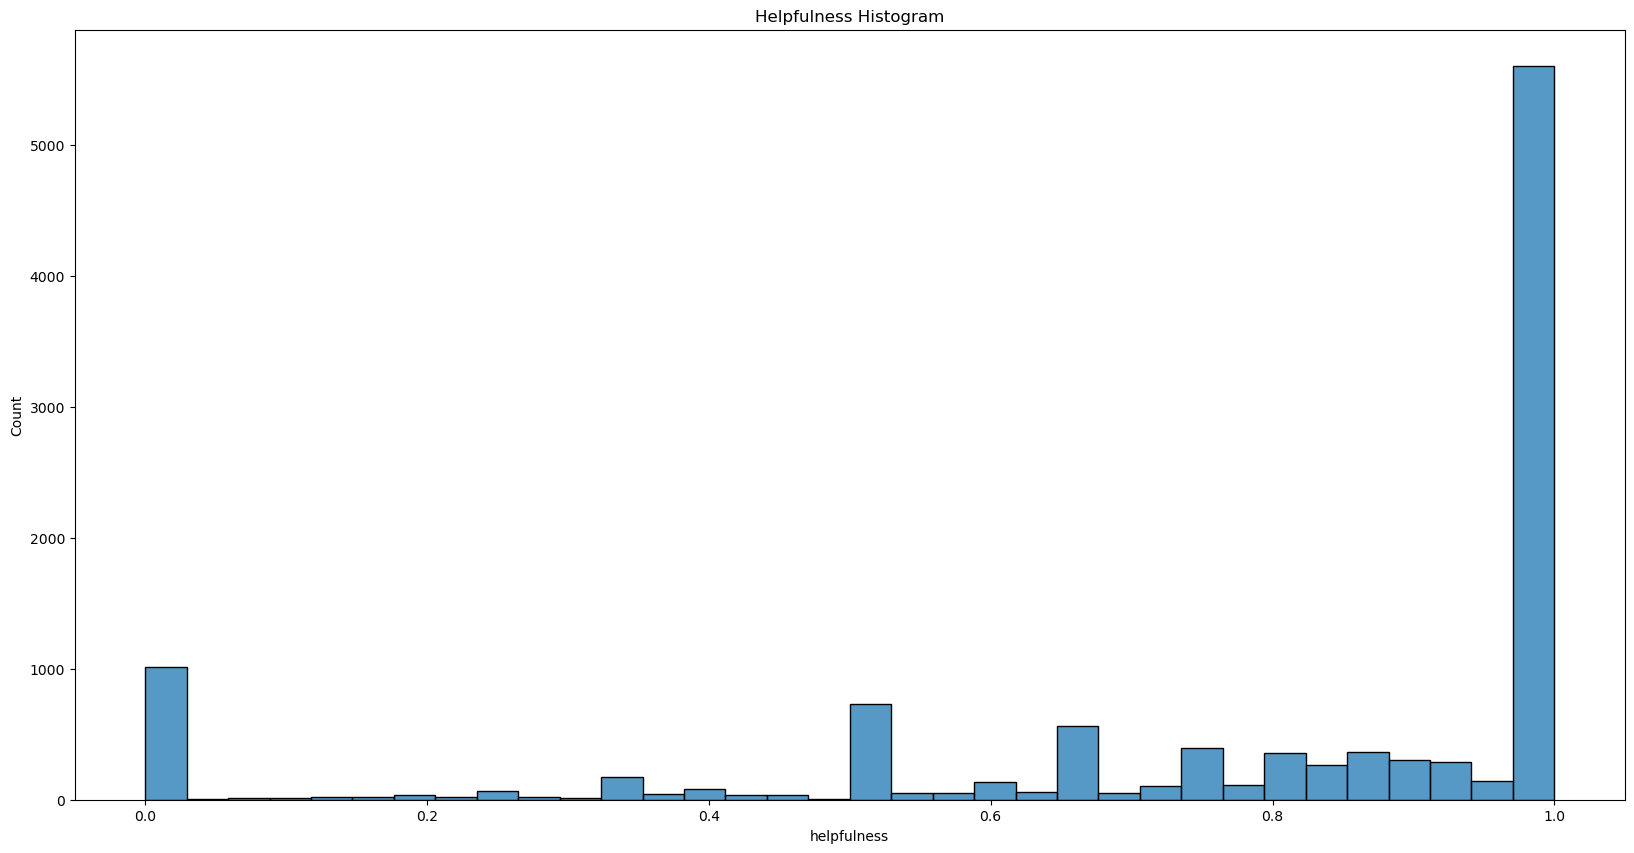

In [15]:
# Helpfulness - also contains a substantial amount of missing values that could impact the variable's use in a model.

# Size
plt.figure(figsize=(20, 10))

# Histogram
helpfulness_hist = sns.histplot(x='helpfulness', data=df2, stat='count')
plt.title('Helpfulness Histogram') # Title

# Show
plt.show()

In [16]:
# Missing values
print(f'There are {df2.helpfulness.isna().sum()} missing values within helpfulness.')

There are 13472 missing values within helpfulness.


A missingness indicator will be calculated for helpfulness because of how many values are missing.

In [17]:
# Collector
helpfulness_missingness = []

# Iterate
for h in range(0, len(df2.helpfulness)):
    if math.isnan(df2.helpfulness[h]):
        helpfulness_missingness.append('missing')
    elif df2.helpfulness[h] < 0.5:
        helpfulness_missingness.append('not helpful')
    elif df2.helpfulness[h] >= 0.5:
        helpfulness_missingness.append('helpful')

# Helpfulness missingness indicator 
df2['helpfulness_missingness'] = helpfulness_missingness

# Check
df2.helpfulness_missingness.describe()

count       24669
unique          3
top       missing
freq        13472
Name: helpfulness_missingness, dtype: object

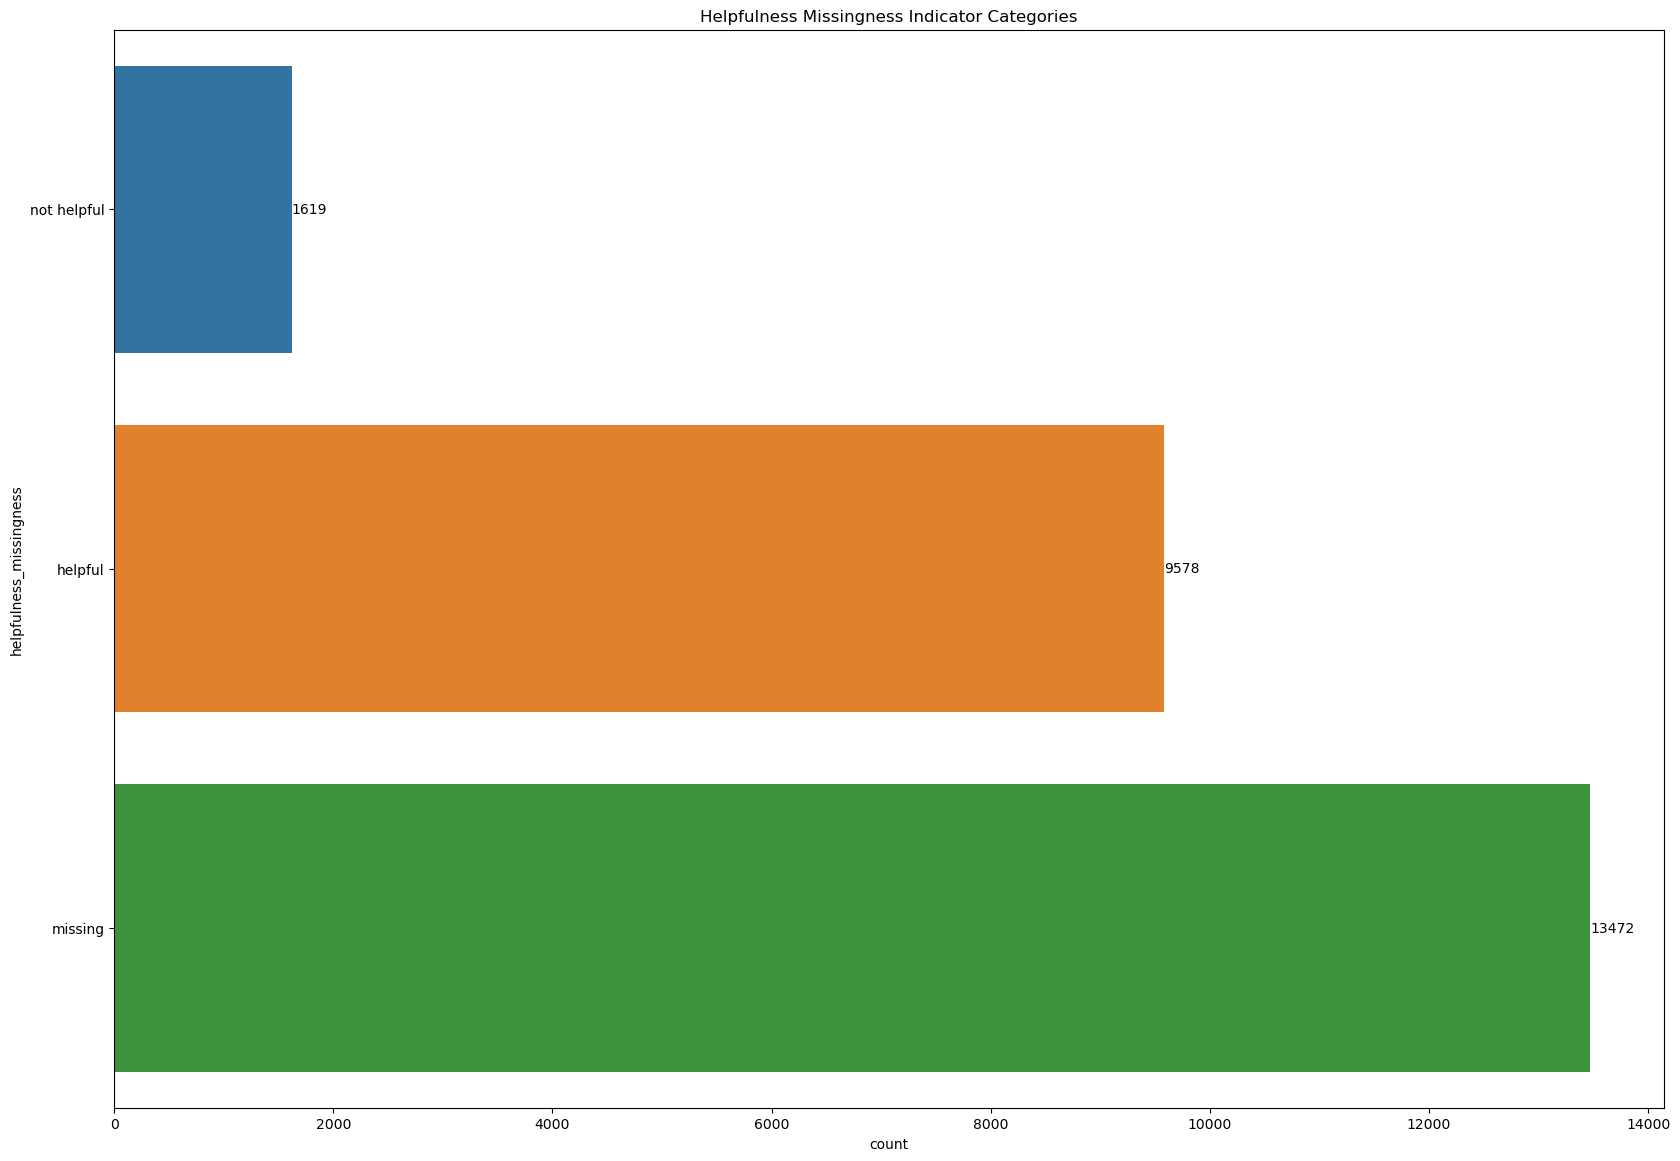

In [18]:
# Visualization
# Size
plt.figure(figsize=(20, 14))

# Countplot - Pie chart made the notebook hang
help_miss_plt = sns.countplot(y='helpfulness_missingness', data=df2)
help_miss_plt.bar_label(help_miss_plt.containers[0]) # Annotations

# Title
plt.title('Helpfulness Missingness Indicator Categories')

# Show
plt.show()

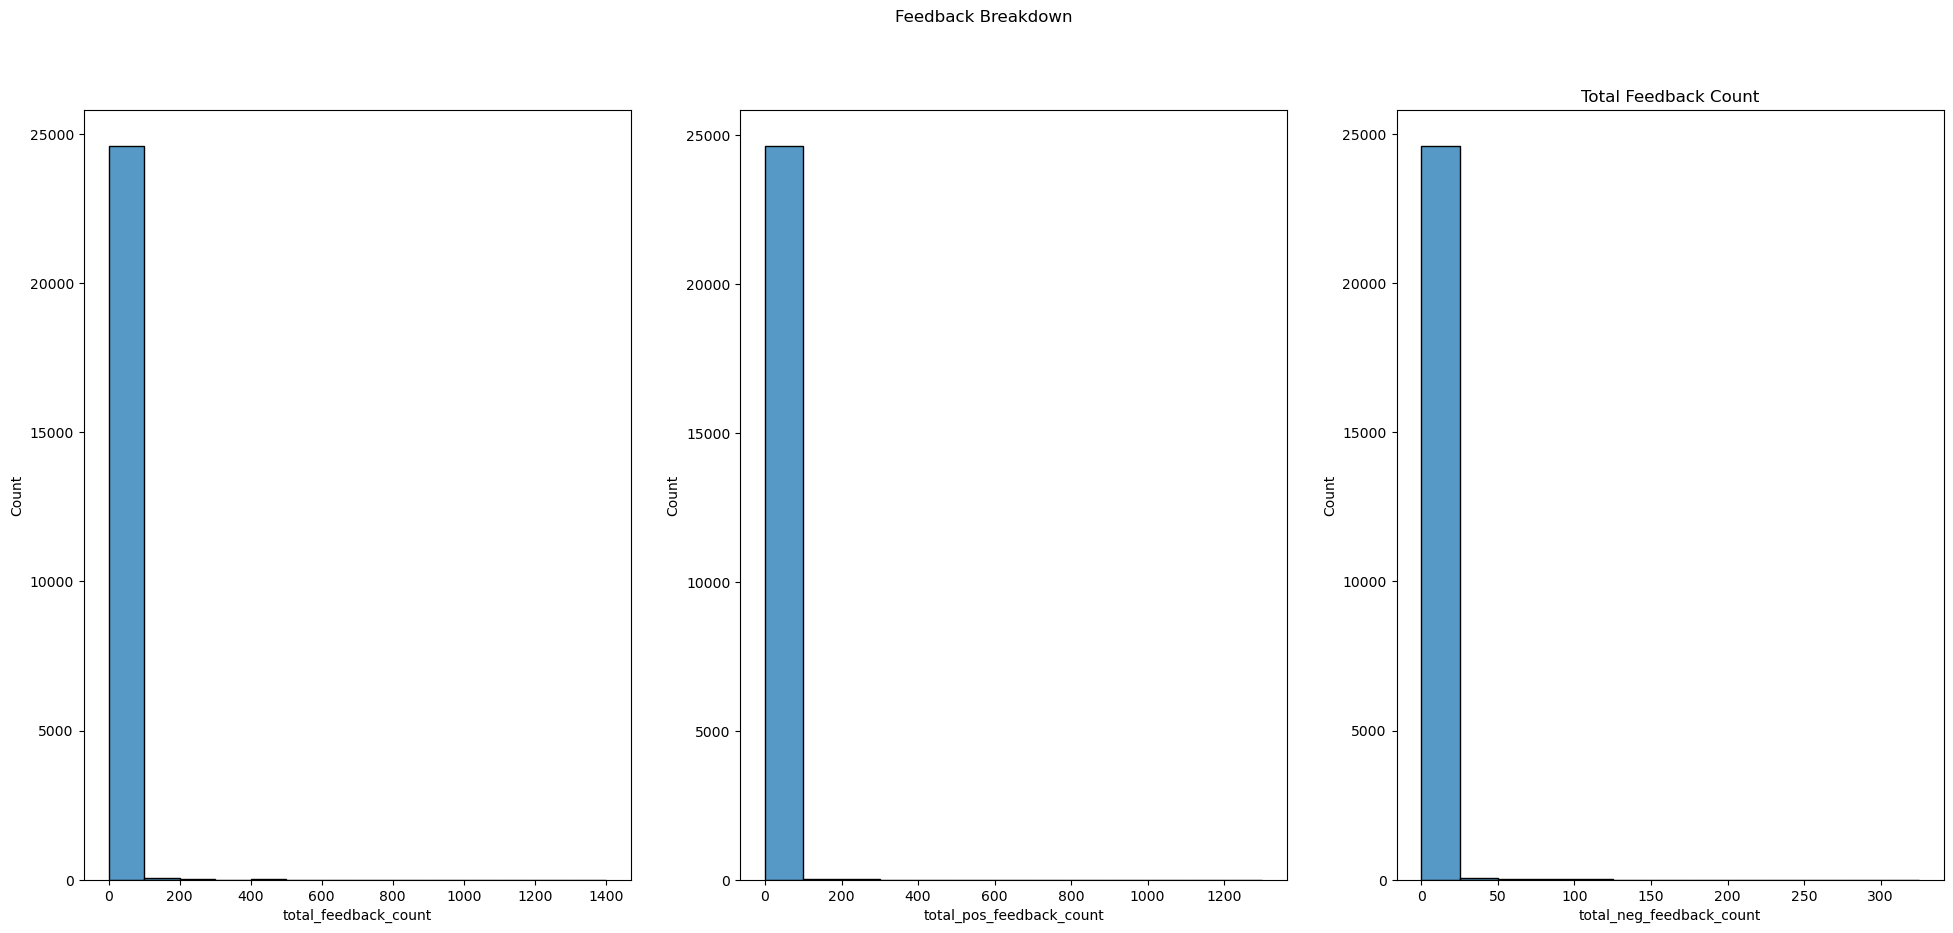

In [19]:
# Total feedback count, total positive feedback, total negative feedback
# Build subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - total feedback
sns.histplot(x='total_feedback_count', binwidth=100, data=df2, ax=ax0)
plt.title('Total Feedback Count')

# ax1 - total positive feedback
sns.histplot(x='total_pos_feedback_count', binwidth=100, data=df2, ax=ax1)
plt.title('Total Positive Feedback Count')

# ax2 - total negative feedback
sns.histplot(x='total_neg_feedback_count', binwidth=25, data=df2, ax=ax2)
plt.title('Total Feedback Count')

# Titling
plt.suptitle('Feedback Breakdown')

# Show
plt.show()

In [20]:
# Submission Time - Split into year, month
df2['year'] = [i.split('-')[0] for i in df2.submission_time]
df2['month'] = [i.split('-')[1] for i in df2.submission_time]

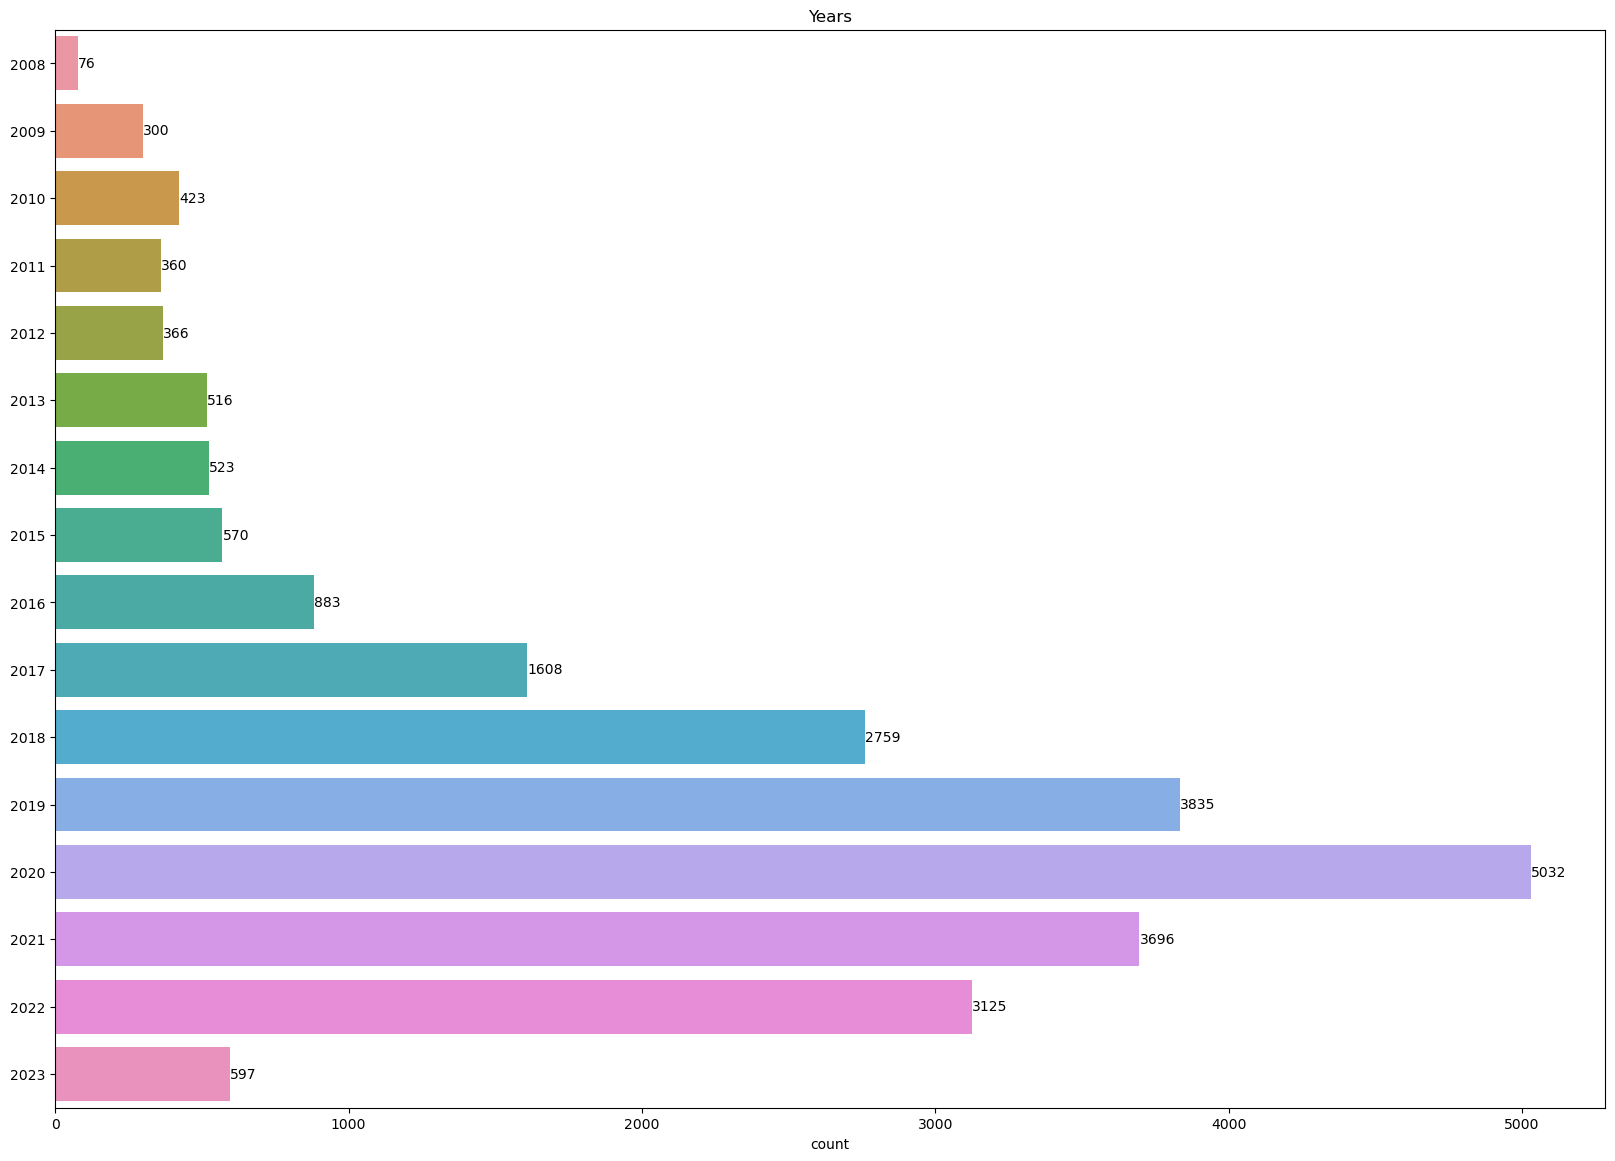

In [21]:
# Breakdown of year
# Size
plt.figure(figsize=(20,14))

# Countplot
year_countplot = sns.countplot(y=sorted(df2['year']), data=df2)
year_countplot.bar_label(year_countplot.containers[0]) # Annotations
plt.title('Years') # Title

# Show
plt.show()

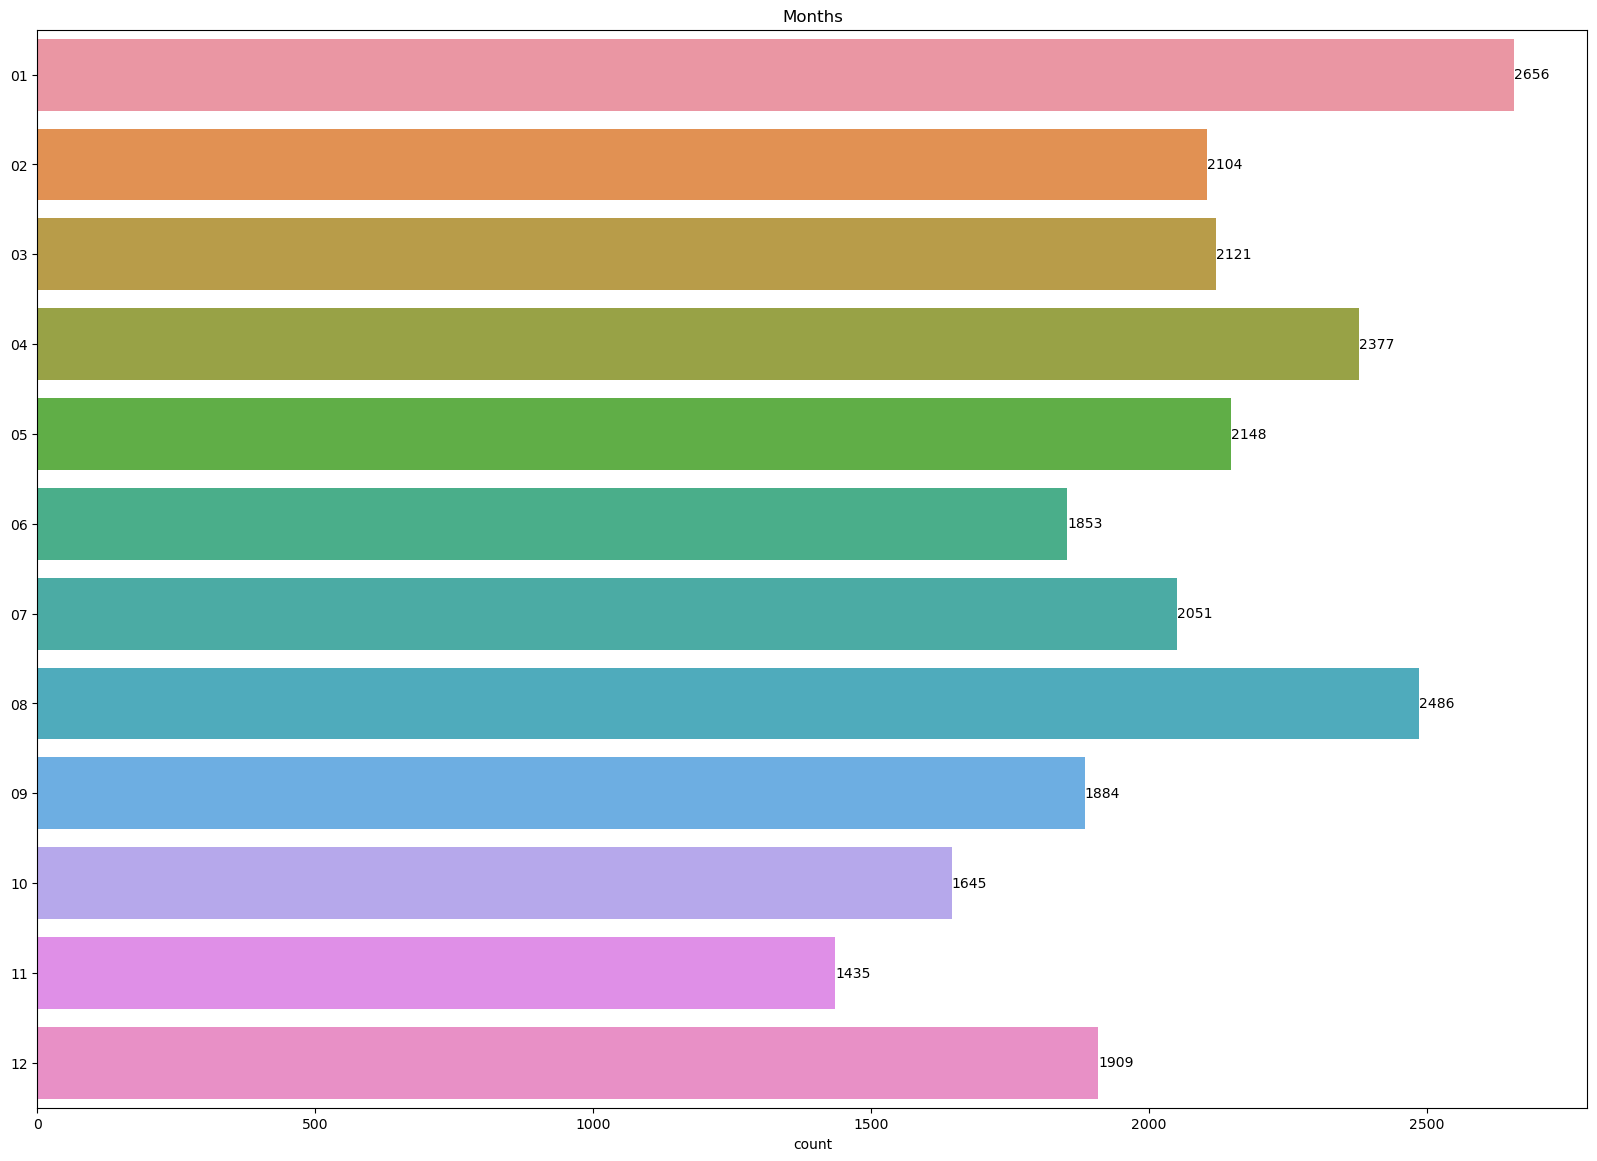

In [22]:
# Break down of month
# Size
plt.figure(figsize=(20,14))

# Countplot
month_countplot = sns.countplot(y=sorted(df2['month']), data=df2)
month_countplot.bar_label(month_countplot.containers[0]) # Annotations
plt.title('Months') # Title

# Show
plt.show()

In [23]:
# Review title - more important to check for the presence of one
print(f'There are {df2.review_title.isna().sum()} reviews missing titles.')

There are 6802 reviews missing titles.


In [24]:
# Skin tone - missing values present
print(f'There are {df2.skin_tone.isna().sum()} missing values for skin tone.')

There are 4340 missing values for skin tone.


In [25]:
# Replace NaN with none
df2.skin_tone.fillna('none', inplace=True)

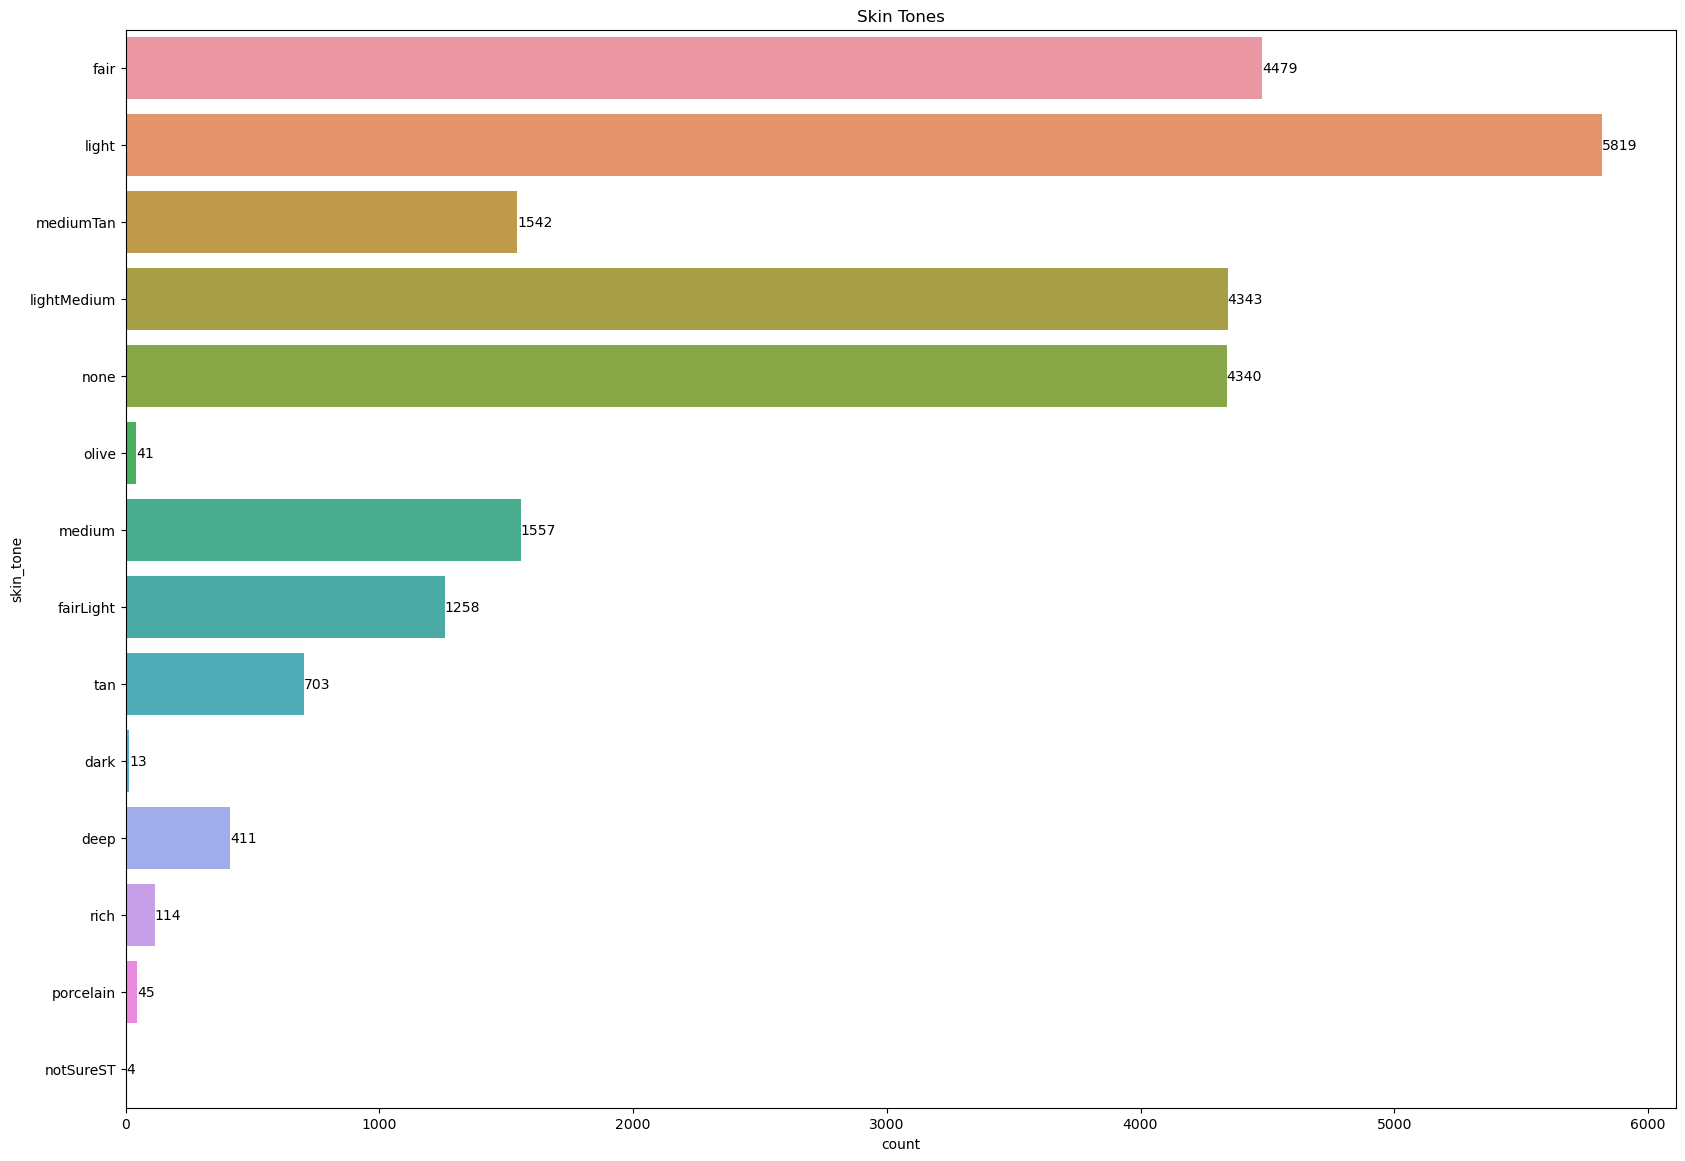

In [26]:
# Visualize skin tone
# Size
plt.figure(figsize=(20,14))

# Countplot
skin_tone_plot = sns.countplot(y='skin_tone', data=df2)
skin_tone_plot.bar_label(skin_tone_plot.containers[0]) # Annotations
plt.title('Skin Tones') # Title

# Show
plt.show()

In [27]:
# Eye color - missing values present
print(f'There are {df2.eye_color.isna().sum()} missing values for eye color.')

There are 5696 missing values for eye color.


In [28]:
# Replace missing values
df2.eye_color.fillna('none', inplace=True)

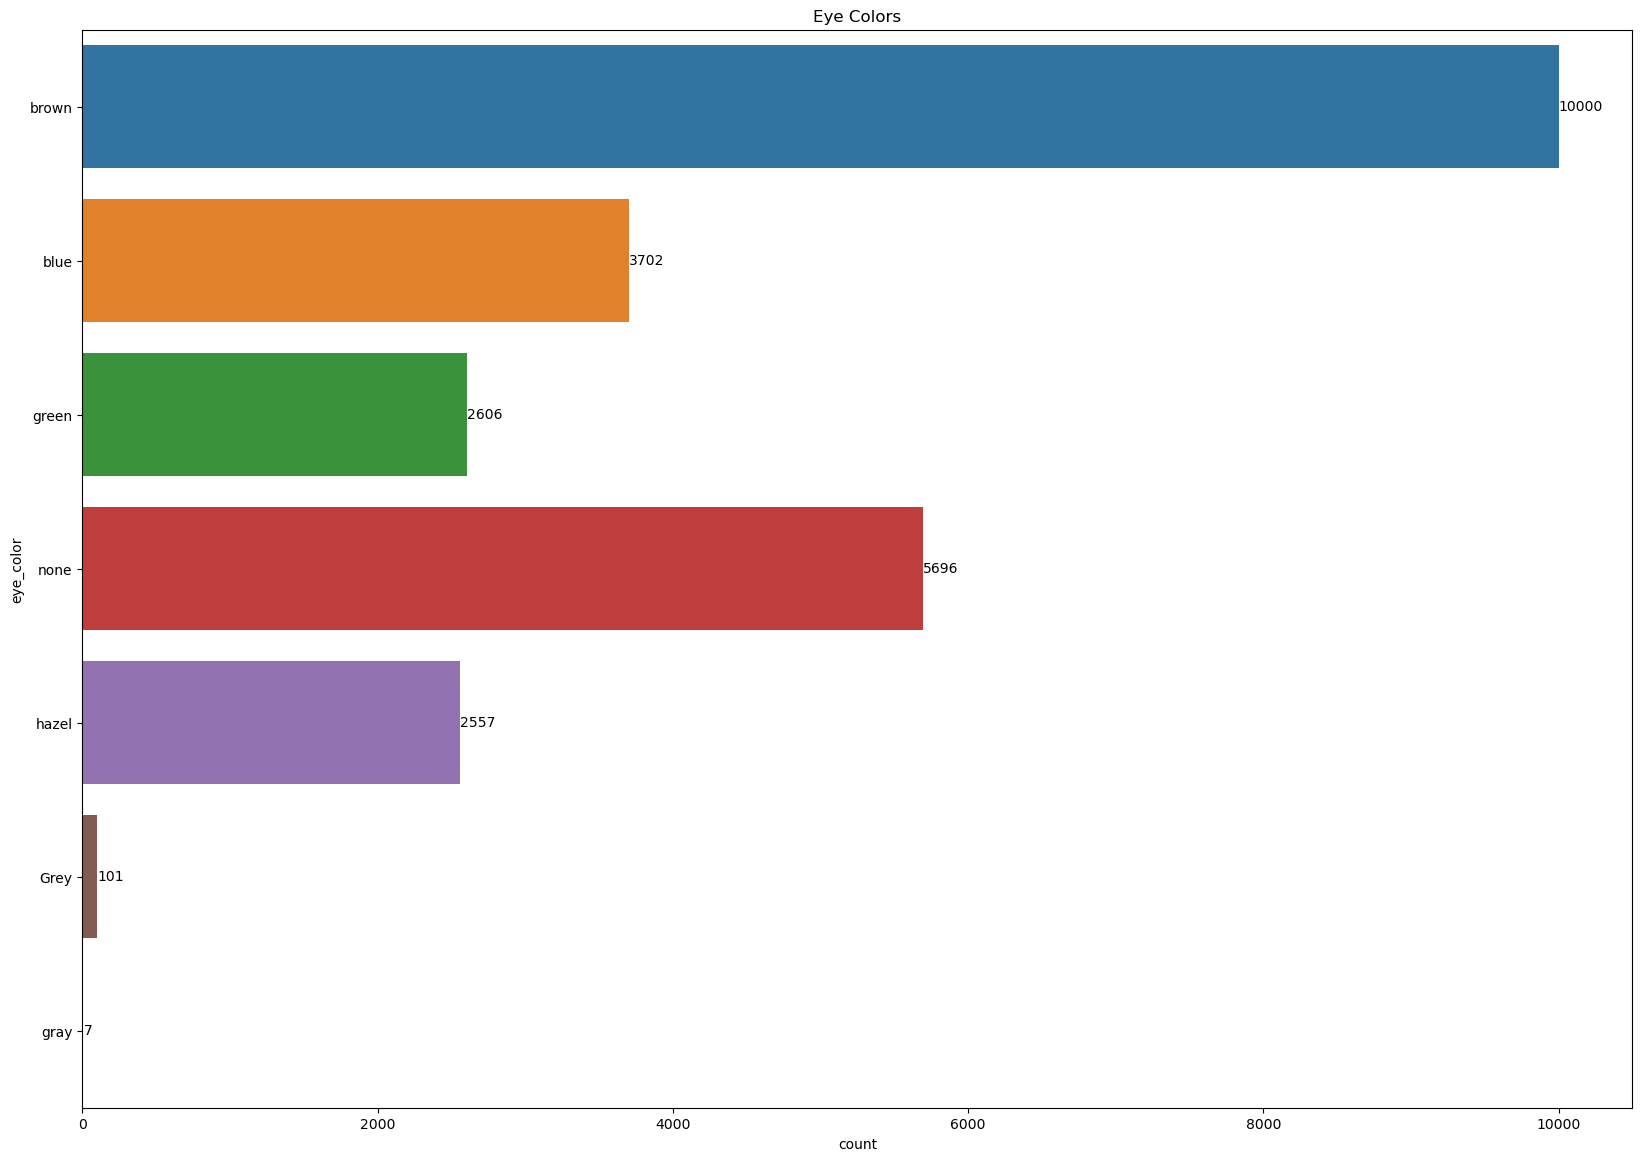

In [29]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
eye_color_plot = sns.countplot(y='eye_color', data=df2)
eye_color_plot.bar_label(eye_color_plot.containers[0]) # Annotations
plt.title('Eye Colors') # Title

# Show
plt.show()

In [30]:
# Skin type - missing values present
print(f'There are {df2.skin_type.isna().sum()} missing values for skin type.')

There are 3078 missing values for skin type.


In [31]:
# Replace missing values
df2.skin_type.fillna('none', inplace=True)

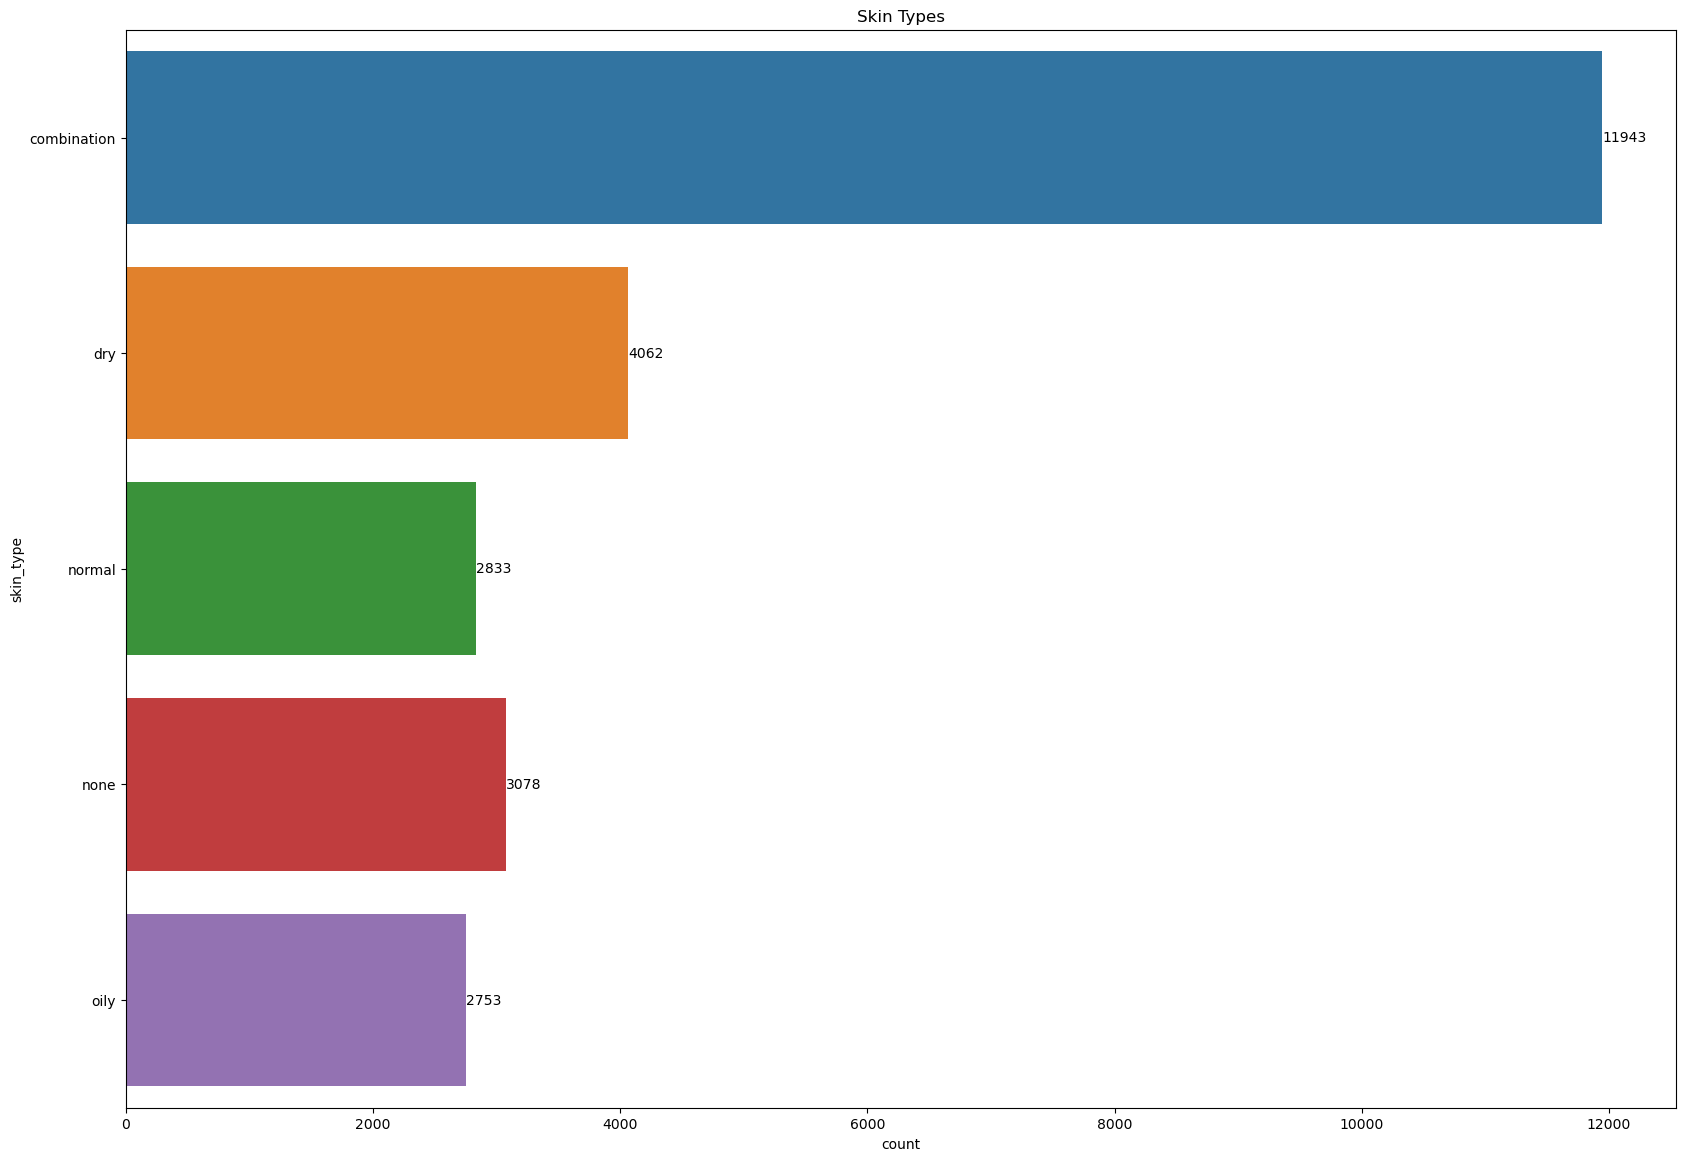

In [32]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
skin_type_plot = sns.countplot(y='skin_type', data=df2)
skin_type_plot.bar_label(skin_type_plot.containers[0]) # Annotations
plt.title('Skin Types') # Title

# Show
plt.show()

In [33]:
# Hair color - missing values present
print(f'There are {df2.hair_color.isna().sum()} missing values for hair color.')

There are 5793 missing values for hair color.


In [34]:
# Replace missing values
df2.hair_color.fillna('none', inplace=True)

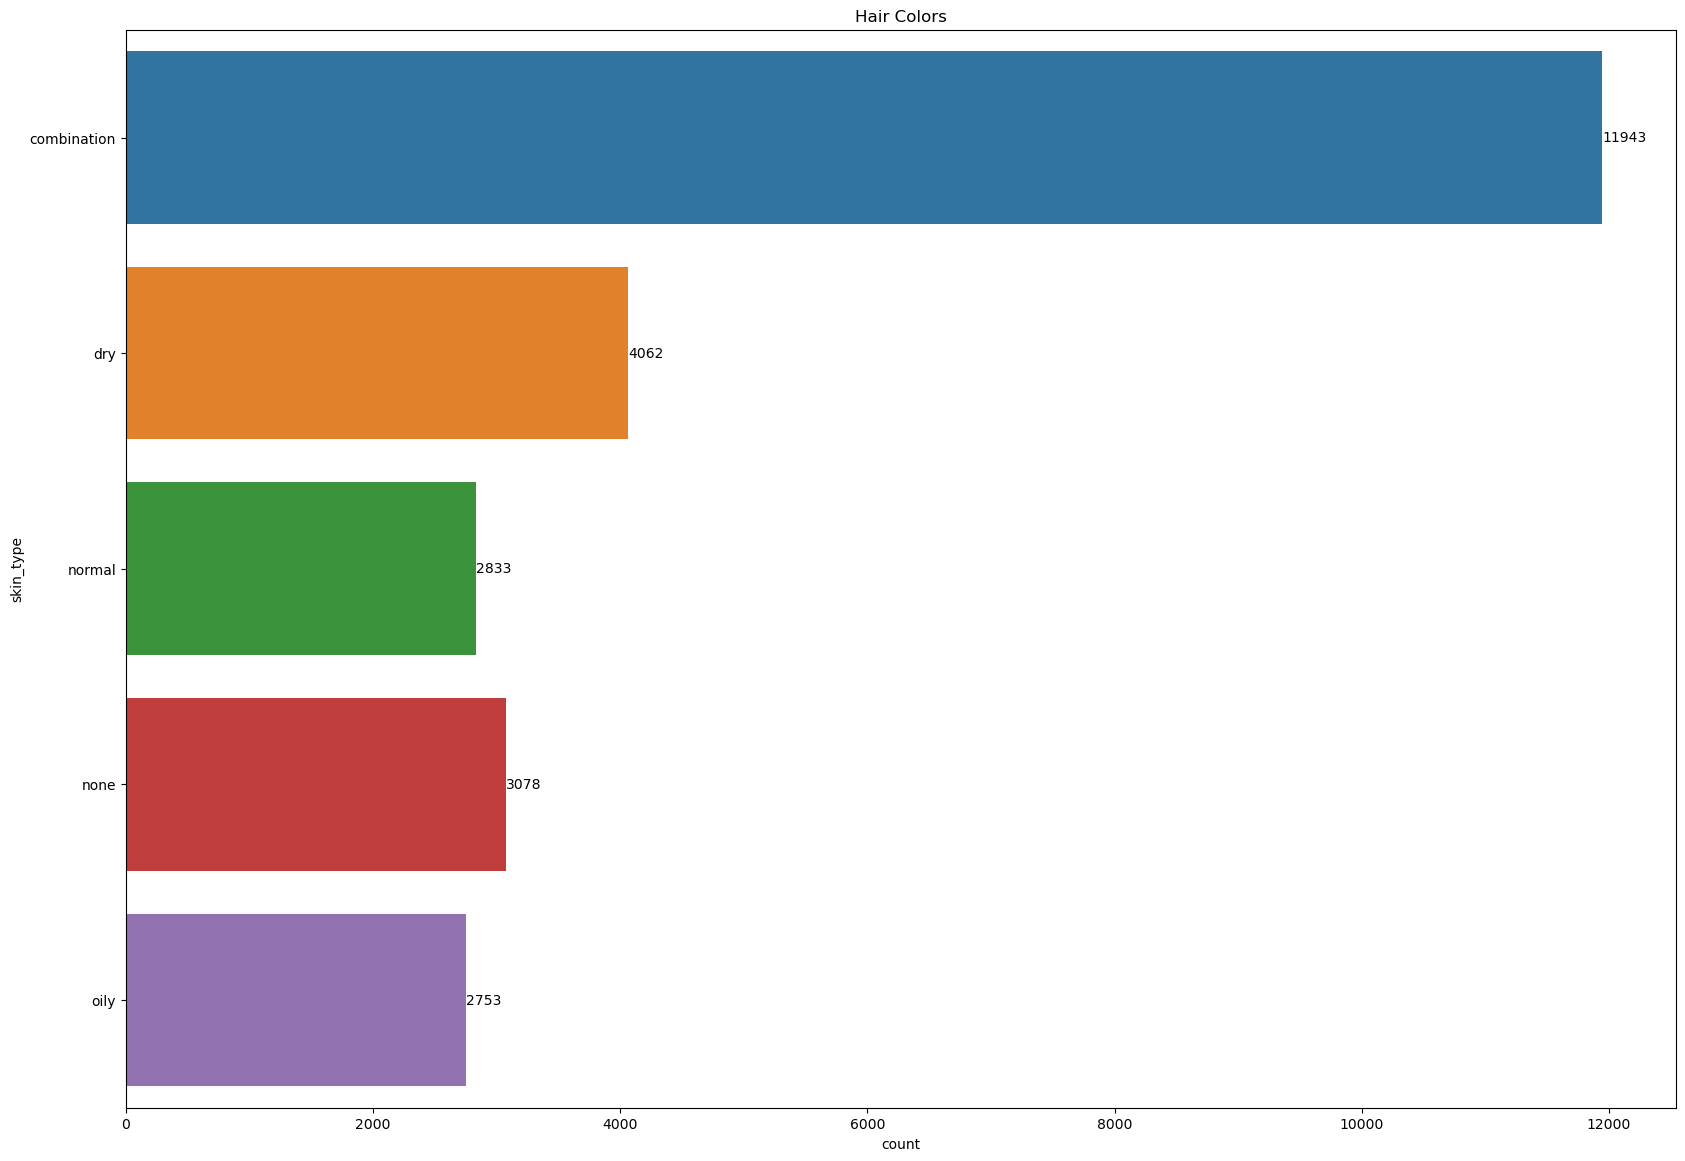

In [35]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
hair_color_plot = sns.countplot(y='skin_type', data=df2)
hair_color_plot.bar_label(hair_color_plot.containers[0]) # Annotations
plt.title('Hair Colors') # Title

# Show
plt.show()

In [36]:
# Product name
print(f'There are {df2.product_name.nunique()} unique product names.')

There are 245 unique product names.


In [37]:
# Brand name
print(f'There are {df2.brand_name.nunique()} unique brand names.')

There are 59 unique brand names.


In [38]:
# Reset the dataframe's index
df2.reset_index(drop=True, inplace=True)

## Prepare the Data Set
- Split into train, validation, and test sets.
- Apply encoders.
- Scale continuous variables.

In [39]:
# For linear regression with price as the target variable
y_linreg = df2.price_usd

# For logistic regression with rating as the target variable
y_logreg = df2.rating

# Linear Regression predictor variables are everything but price_usd
x_linreg = df2.drop(["price_usd", "review_text", "review_title", "submission_time", "product_name", "brand_name", "helpfulness"], axis=1)

# Logistic Regression predictor variables are everything but ratings
x_logreg = df2.drop(["rating", "review_text", "review_title", "submission_time", "product_name", "brand_name", "helpfulness"], axis=1)

### Focus on Linear Regression Preparation

In [40]:
# Split the data - Linear regression
xlin_train, xlin_test_base, ylin_train, ylin_test_base = train_test_split(x_linreg, y_linreg, test_size = .20, random_state=42)

# Create validation and test - Linear regression
xlin_valid, xlin_test, ylin_valid, ylin_test = train_test_split(xlin_test_base, ylin_test_base, test_size = .50, random_state = 42)

In [41]:
# Check shapes
print(f'Linear regression training set size: {xlin_train.shape[0]} | Validation set size: {xlin_valid.shape[0]} | Test set size: {xlin_test.shape[0]}')

Linear regression training set size: 19735 | Validation set size: 2467 | Test set size: 2467


At this point, there is a trade off to be made between lines of code and readability. ColumnTransformer works best with columns selected by dtype, but not all columns of the same dtype need to be processed similarly. A good option is to split the dataframe into multiple dataframes, apply the transformers with their output as dataframes, and then rejoin all the dataframes together again. It adds more lines of code, but it ensures no issues using ColumnTransformer.

These same steps will also need to be performed on the validation and test sets, too.

In [42]:
# Review the dataframe
xlin_train.head(2)

,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,skin_tone,eye_color,skin_type,hair_color,gpt_vectors,helpfulness_missingness,year,month
15647,4,1.0,1,0,1,fair,brown,combination,brown,"[-0.0015796941006556153, -0.00995077844709158,...",helpful,2021,04
1553,5,1.0,0,0,0,light,brown,combination,black,"[-0.009651311673223972, -0.002177625196054578,...",missing,2023,02


The dataframes will be broken out as follows:
- rating and is_recommended: xtrain_review_stat, xvalid_review_stat, xtest_review_stat
- total_feedback_count, total_neg_feedback_count, total_pos_feedback_count: xtrain_feedback, xvalid_feedback, xtest_feedback
- skin_tone, eye_color, skin_type, hair_color, helpfulness_missingness: xtrain_strings, xvalid_strings, xtest_strings
- year, month: xtrain_date, xvalid_date, xtest_date

gpt_vectors will not need to be transformed, and so once the respective data sets are rejoined, gpt_vectors will be added as well.

#### Split Data Sets

In [43]:
# Names of isolations
isolations = {'review_stat': ['rating', 'is_recommended'],
              'feedback': ['total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count'],
              'strings': ['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'helpfulness_missingness'],
              'date': ['year', 'month']}

# Function to create dataframe splits
def dfSplits(dataframe, split_name):
    """
    Splits a dataframe and then returns a new dataframe based on splits.
    Dataframe names are dynamic by a combination of prefix and split_names.
    """
    # Return a new dataframe
    return dataframe[split_name]

In [44]:
# Training data
for i in isolations.keys():
    globals()['xtrain_'+i] = dfSplits(xlin_train, isolations[i])

In [45]:
# Validation data
for i in isolations.keys():
    globals()['xvalid_'+i] = dfSplits(xlin_valid, isolations[i])

In [46]:
# Test data
for i in isolations.keys():
    globals()['xtest_'+i] = dfSplits(xlin_test, isolations[i])

#### Transformers and Reconstruct Data Sets

In [47]:
# Review stat
review_stat_linreg_cols = xtrain_review_stat.select_dtypes(exclude='object').columns # Apply ordinal encoder

# Feedback columns
feedback_linreg_cols = xtrain_feedback.select_dtypes(include='int64').columns # Apply MaxAbsScaler

# Strings
strings_linreg_cols = xtrain_strings.select_dtypes(include='object').columns # Apply ordinal encoder

# Date
date_linreg_cols = xtrain_date.select_dtypes(include='object').columns # Apply ordinal encoder

In [48]:
# Transformers
# review_stat column transformer
review_stat_linreg_tfrm = ColumnTransformer([('review_stat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100), review_stat_linreg_cols)],
                                        remainder='passthrough') # rating and is_recommended

# feedback column transformer
total_feedback_linreg_tfrm = ColumnTransformer([('total_feedbacks', MaxAbsScaler(), feedback_linreg_cols)],
                                           remainder='passthrough') # total feedbacks

# strings column transformer
strings_linreg_tfrm = ColumnTransformer([('string_categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100), strings_linreg_cols)],
                                        remainder='passthrough') # strings

# date column transformer
date_linreg_tfrm = ColumnTransformer([('date_categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100), date_linreg_cols)],
                                     remainder='passthrough')

# Target variable
price_linreg_tfrm = LabelEncoder()

In [49]:
# Apply transformers to training set
xtrain_review_stat = review_stat_linreg_tfrm.fit_transform(xtrain_review_stat)
xtrain_feedback = total_feedback_linreg_tfrm.fit_transform(xtrain_feedback)
xtrain_strings = strings_linreg_tfrm.fit_transform(xtrain_strings)
xtrain_date = date_linreg_tfrm.fit_transform(xtrain_date)

# Target variable
ylin_train = price_linreg_tfrm.fit_transform(ylin_train)

In [50]:
# Rejoin the xtrain sets
xlr_train = xtrain_review_stat.join([xtrain_feedback, xtrain_strings, xtrain_date], how='left')

# Append 
xlr_train['gpt_vectors'] = xlin_train.gpt_vectors

# Show
xlr_train.head(3)

,review_stat__rating,review_stat__is_recommended,total_feedbacks__total_feedback_count,total_feedbacks__total_neg_feedback_count,total_feedbacks__total_pos_feedback_count,string_categorical__skin_tone,string_categorical__eye_color,string_categorical__skin_type,string_categorical__hair_color,string_categorical__helpfulness_missingness,date_categorical__year,date_categorical__month,gpt_vectors
15647,3.0,1.0,0.000845,0.0,0.000929,2.0,2.0,0.0,3.0,0.0,13.0,3.0,"[-0.0015796941006556153, -0.00995077844709158,..."
1553,4.0,1.0,0.000000,0.0,0.000000,4.0,2.0,0.0,1.0,1.0,15.0,1.0,"[-0.009651311673223972, -0.002177625196054578,..."
18898,4.0,2.0,0.000000,0.0,0.000000,8.0,6.0,2.0,6.0,1.0,4.0,7.0,"[-0.02363215759396553, 0.0022855051793158054, ..."


In [51]:
# Apply transformations to validation sets
xvalid_review_stat = review_stat_linreg_tfrm.transform(xvalid_review_stat)
xvalid_feedback = total_feedback_linreg_tfrm.transform(xvalid_feedback)
xvalid_strings = strings_linreg_tfrm.transform(xvalid_strings)
xvalid_date = date_linreg_tfrm.transform(xvalid_date)

# Target variable
ylin_valid = price_linreg_tfrm.transform(ylin_valid)

In [52]:
# Rejoin the xvalid sets
xlr_valid = xvalid_review_stat.join([xvalid_feedback, xvalid_strings, xvalid_date], how='left')

# Append 
xlr_valid['gpt_vectors'] = xlin_valid.gpt_vectors

# Show
xlr_valid.head(3)

,review_stat__rating,review_stat__is_recommended,total_feedbacks__total_feedback_count,total_feedbacks__total_neg_feedback_count,total_feedbacks__total_pos_feedback_count,string_categorical__skin_tone,string_categorical__eye_color,string_categorical__skin_type,string_categorical__hair_color,string_categorical__helpfulness_missingness,date_categorical__year,date_categorical__month,gpt_vectors
15068,4.0,1.0,0.000845,0.0,0.000929,4.0,2.0,0.0,3.0,0.0,13.0,0.0,"[0.015080357901751995, 0.0058496990241110325, ..."
4966,4.0,2.0,0.000000,0.0,0.000000,8.0,6.0,0.0,6.0,1.0,6.0,3.0,"[-0.0129879554733634, 0.006638860329985619, 0...."
13938,4.0,1.0,0.000000,0.0,0.000000,4.0,1.0,0.0,2.0,1.0,11.0,0.0,"[-0.01650683954358101, 0.00237525743432343, 0...."


In [53]:
# Apply transformations to test sets
xtest_review_stat = review_stat_linreg_tfrm.transform(xtest_review_stat)
xtest_feedback = total_feedback_linreg_tfrm.transform(xtest_feedback)
xtest_strings = strings_linreg_tfrm.transform(xtest_strings)
xtest_date = date_linreg_tfrm.transform(xtest_date)

# Target variable
ylin_test = price_linreg_tfrm.transform(ylin_test)

In [54]:
# Rejoin the xtest sets
xlr_test = xtest_review_stat.join([xtest_feedback, xtest_strings, xtest_date], how='left')

# Append 
xlr_test['gpt_vectors'] = xlin_test.gpt_vectors

# Show
xlr_test.head(3)

,review_stat__rating,review_stat__is_recommended,total_feedbacks__total_feedback_count,total_feedbacks__total_neg_feedback_count,total_feedbacks__total_pos_feedback_count,string_categorical__skin_tone,string_categorical__eye_color,string_categorical__skin_type,string_categorical__hair_color,string_categorical__helpfulness_missingness,date_categorical__year,date_categorical__month,gpt_vectors
17981,4.0,2.0,0.0,0.0,0.0,8.0,6.0,2.0,6.0,1.0,9.0,0.0,"[-0.010172180831432343, -0.0033530043438076973..."
24115,2.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,3.0,1.0,13.0,7.0,"[-7.698550325585529e-05, 0.012754382565617561,..."
6346,4.0,1.0,0.0,0.0,0.0,4.0,1.0,4.0,3.0,1.0,13.0,0.0,"[-0.012329447083175182, 0.005381901282817125, ..."


## Multicollinearity Checks

Merge the train, valiation, and test sets.

In [55]:
# Merged dataframe
xlr_merged = pd.concat([xlr_train, xlr_valid, xlr_test], axis=0)

ylr_merged = np.concatenate([ylin_train, ylin_valid, ylin_test], axis=0)

# Append target variable again
xlr_merged['price_in_usd'] = ylr_merged

# Check
xlr_merged.shape

(24669, 14)

/tmp/ipykernel_20/1308243308.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(xlr_merged.corr(), annot=True)


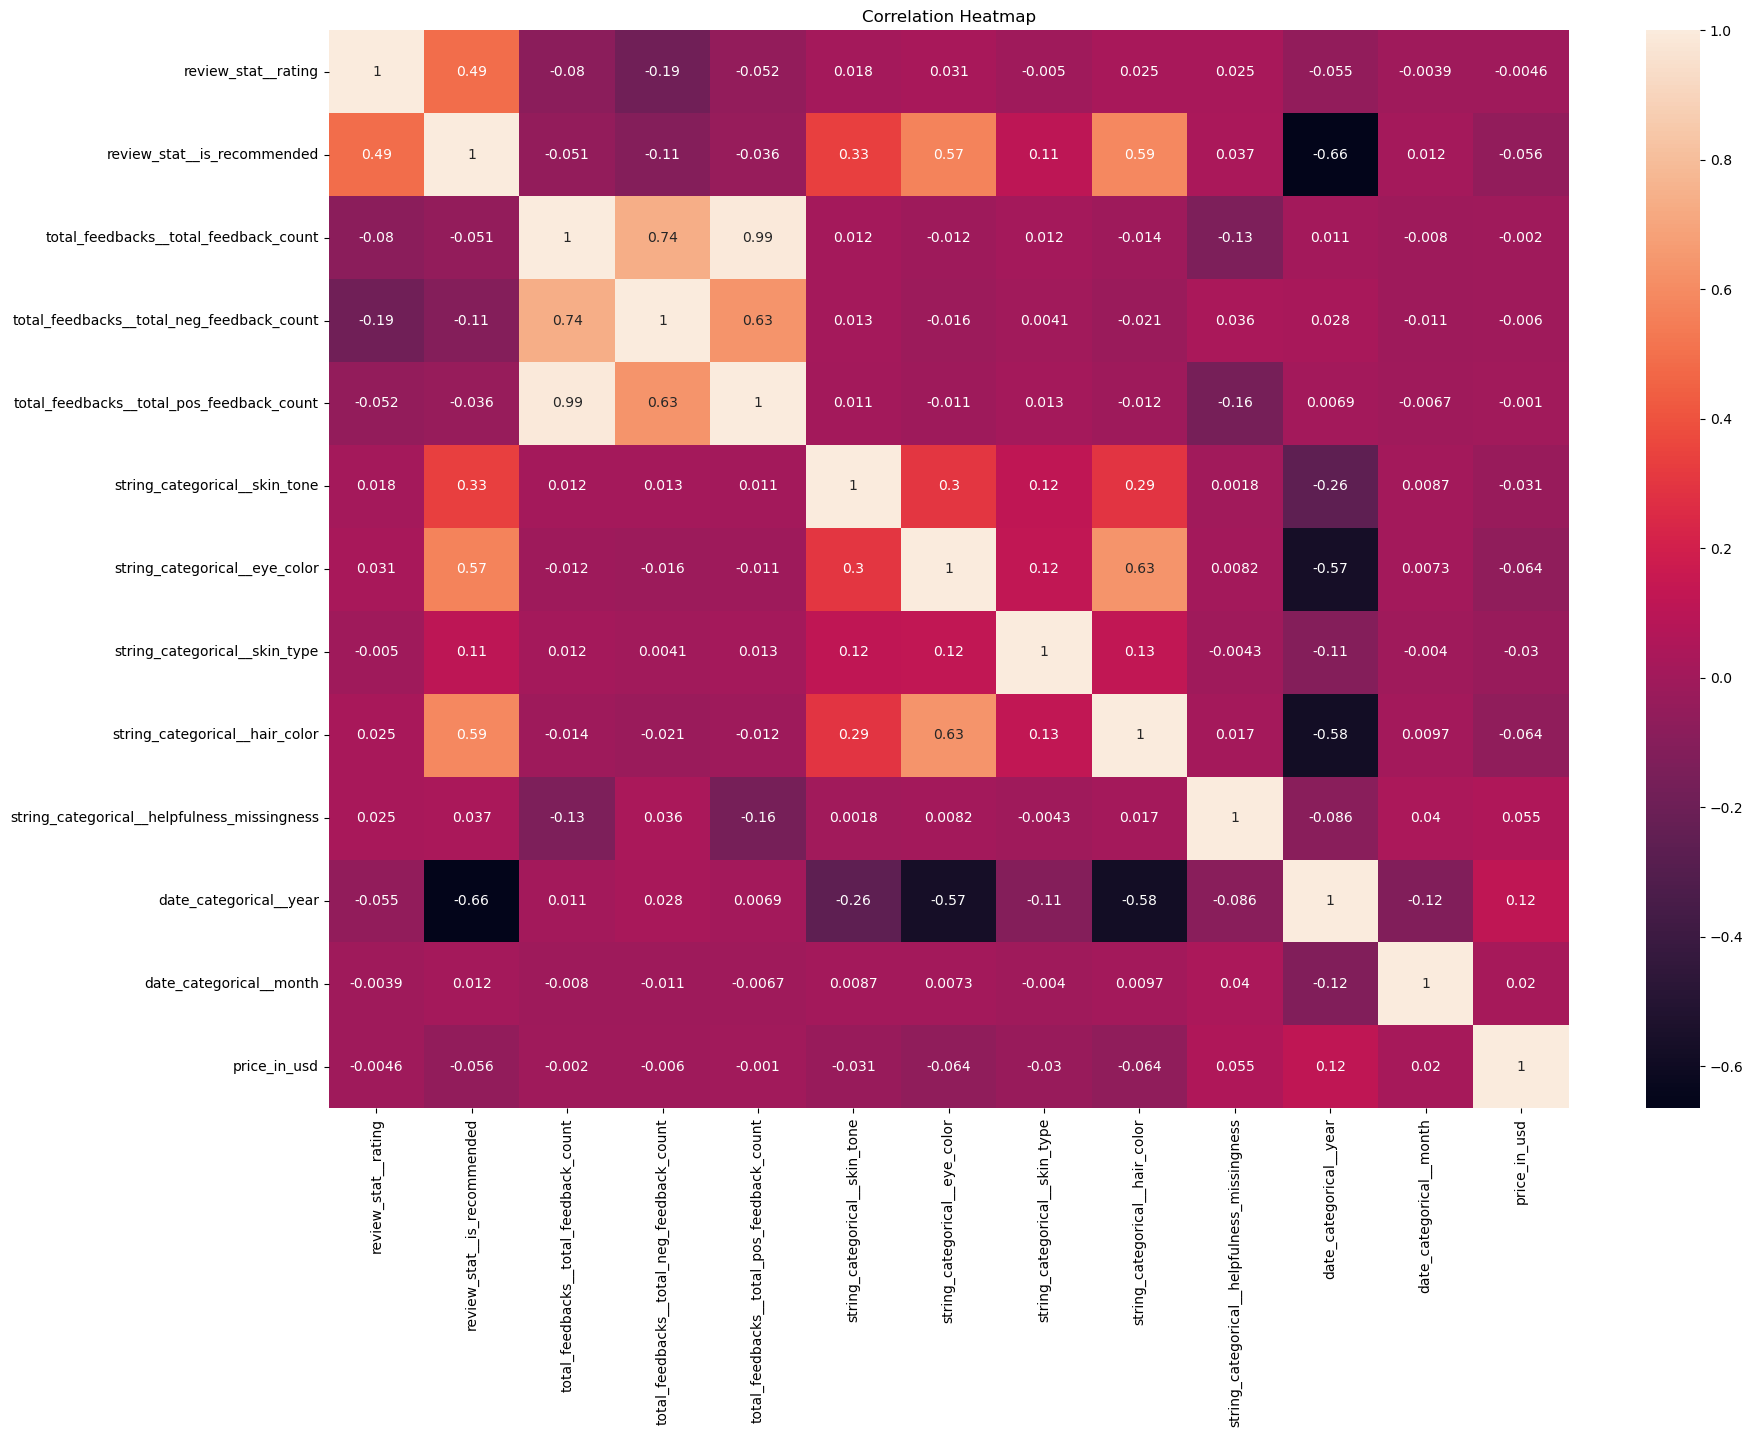

In [56]:
# Visualize - won't include gpt_vectors
# Size
plt.figure(figsize=(20,14))

# Heatmap
sns.heatmap(xlr_merged.corr(), annot=True)

# Title
plt.title('Correlation Heatmap')

# Show
plt.show()

## Linear Regression

This will aim to predict Price (USD).